```{currentmodule} tskit
```

In [1]:
from IPython.display import display

(sec_export)=

# Data export

(sec_export_vcf)=
## Variant Call Format

Tskit supports exporting data to the standard
[Variant Call Format](http://samtools.github.io/hts-specs/VCFv4.3.pdf)
via the `tskit vcf` {ref}`command line interface<sec_cli>` command
and the {meth}`TreeSequence.write_vcf` method in the {ref}`sec_python_api`.
Conversion is quite efficient, with tskit producing VCF data at several
hundred megabytes per second (for large files), which is usually as fast as
it can be written to storage or consumed by programs in a pipeline.

::::{tip}
If we have a tree sequence file the
{ref}`command line interface<sec_cli>` is often the most
convenient way to convert to VCF:

:::{code-block} bash
$ tskit vcf example.trees > example.vcf
:::

See the {ref}`sec_export_vcf_compression` section for information
on how to compress the VCF output.
::::

For tree sequences produced by recent versions of programs such as
``msprime``, ``SLiM``, ``fwdpy11`` or ``tsinfer``, VCF output will
"do the right thing" and no further arguments are needed.
For example, here we simulate 3 diploid individuals
with mutations using ``msprime``, and convert to VCF.

In [2]:
import sys
import msprime
ts = msprime.sim_ancestry(
    samples=3, ploidy=2, sequence_length=10, random_seed=2)
ts = msprime.sim_mutations(ts, rate=0.1, random_seed=2)
ts.write_vcf(sys.stdout)

##fileformat=VCFv4.2
##source=tskit 0.5.3
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1	tsk_2
1	2	0	A	T,G	.	PASS	.	GT	0|0	0|0	2|2
1	3	1	C	T	.	PASS	.	GT	0|0	0|1	0|0
1	4	2	G	C	.	PASS	.	GT	1|0	1|1	0|0
1	6	3	C	T	.	PASS	.	GT	1|0	1|1	0|0
1	9	4	A	C	.	PASS	.	GT	0|0	1|0	0|0


In the output VCF we have 3 diploid samples
(see the {ref}`sec_export_vcf_terminology` section)
corresponding to samples specified in the ancestry simulation
with IDs ``tsk_0``, ``tsk_1`` and ``tsk_2``
(see the {ref}`sec_export_vcf_individual_names`
section for how to override these default labels).
We then have a line for every row
in the {ref}`site table<sec_site_table_definition>`, and
the data is derived directly from the {meth}`TreeSequence.variants`
method; e.g.

In [3]:
for var in ts.variants():
    print(var.site.position, var.site.id, var.alleles, var.genotypes, sep="\t")

2.0	0	('A', 'T', 'G')	[0 0 0 0 2 2]
3.0	1	('C', 'T')	[0 0 0 1 0 0]
4.0	2	('G', 'C')	[1 0 1 1 0 0]
6.0	3	('C', 'T')	[1 0 1 1 0 0]
9.0	4	('A', 'C')	[0 0 1 0 0 0]


We can see the ``POS`` value is equal to the site's position
(see the {ref}`sec_export_vcf_modifying_coordinates` for information
on how we deal with continuous coordinates), the ``ID`` value
is the site's ID, and the ``REF`` and ``ALT`` values
are derived from the variant's ``alleles``.

The ``GT`` values for the three diploid individuals are derived from the
variant's genotypes (see the {ref}`sec_export_vcf_terminology` section).
For this simulation, the diploid individuals correspond to
adjacent sample nodes in order, and we can see there is a direct
correspondence between the phased ``GT`` values and variant's genotypes.
See the {ref}`sec_export_vcf_constructing_gt` section for
more information on how this done in general and for options
to control the VCF sample and ``GT`` values.

::::{important}
In these examples we write the VCF data to ``sys.stdout`` so that we can see
the output. Usually, however, you'd write to a file:

:::{code-block}
with open("output.vcf", "w") as vcf_file:
    ts.write_vcf(vcf_file)
:::

:::{seealso}
See the {ref}`sec_export_vcf_compression` section for information
on how to compress the output or convert to BCF.
:::

::::

(sec_export_vcf_terminology)=

### Terminology

There are some mismatches between the terminology for tskit and VCF.
In VCF a "sample" is a multiploid individual, but in tskit a sample
refers to a single **node** (monoploid genome), and an individual
consists of one or more nodes (e.g., two nodes for a diploid).
Similarly, in VCF a "genotype" refers to the observed allelic state
for a sample **individual** at a particular site,
whereas in tskit a genotype is the observed allelic state
for a **node** (see {attr}`.Variant.genotypes`).

:::{seealso}
See the {ref}`sec_glossary` for more details on tskit's data model
 and terminology.
:::

(sec_export_vcf_compression)=

### Compressed output

The simplest way to compress the VCF output is to use the
`tskit vcf` {ref}`command line interface<sec_cli>`
and pipe the output to `bgzip`:

:::{code-block} bash
$ tskit vcf example.trees | bgzip -c > example.vcf.gz
:::
A general way to convert VCF data to various formats is to pipe the text
produced by ``tskit`` into ``bcftools`` using the command
line interface:

:::{code-block} bash
$ tskit vcf example.trees | bcftools view -O b > example.bcf
:::

If you need more control over the form of the output (or want to work
directly in Python), the following recipe has the same effect:

:::{code-block}

import os
import subprocess

read_fd, write_fd = os.pipe()
write_pipe = os.fdopen(write_fd, "w")
with open("output.bcf", "w") as bcf_file:
    proc = subprocess.Popen(
        ["bcftools", "view", "-O", "b"], stdin=read_fd, stdout=bcf_file
    )
    ts.write_vcf(write_pipe)
    write_pipe.close()
    os.close(read_fd)
    proc.wait()
    if proc.returncode != 0:
        raise RuntimeError("bcftools failed with status:", proc.returncode)
:::


The VCF output can also be compressed using the {mod}`gzip` Python module:

:::{code-block}

import gzip

with gzip.open("output.vcf.gz", "wt") as f:
    ts.write_vcf(f)
:::

However, this gzipped VCF won't be fully compatible with downstream tools
such as tabix, which usually require the VCF to use the specialised bgzip format.

(sec_export_vcf_masking_output)=

### Masking output

The {meth}`TreeSequence.write_vcf` method provides the
``site_mask`` and ``sample_mask`` arguments to
omit or mark parts of the output as missing.

In [4]:
ts = msprime.sim_ancestry(
    samples=3, ploidy=2, sequence_length=10, random_seed=2)
ts = msprime.sim_mutations(ts, rate=0.1, random_seed=2)
ts.tables.sites

id,position,ancestral_state,metadata
0,2,A,
1,3,C,
2,4,G,
3,6,C,
4,9,A,


The ``sample_mask`` argument provides a general way to mask out
parts of the output, which can be helpful when simulating missing
data. In this (contrived) example, we create a sample mask function
that marks one genotype missing in each variant in a regular
pattern:

:::{code-block}

def sample_mask(variant):
    sample_mask = np.zeros(ts.num_samples, dtype=bool)
    sample_mask[variant.site.id % ts.num_samples] = 1
    return sample_mask


ts.write_vcf(sys.stdout, sample_mask=sample_mask)
:::

(sec_export_vcf_constructing_gt)=

### Constructing GT values

The core elements of the tskit
{ref}`data model<sec_data_model>`
are {ref}`nodes<sec_node_table_definition>`,
{ref}`edges<sec_node_table_definition>`,
{ref}`sites<sec_site_table_definition>` and
{ref}`mutations<sec_mutation_table_definition>`.
These four tables allow us to completely describe the
genetic ancestry of a set of sampled monoploid
genomes and their genetic variation.
The {ref}`individual table<sec_individual_table_definition>`
defines a set of individual *organisms*, and it can
be used to define the inheritance relationships between
then (the pedigree). An individual may be associated
with one or more nodes, and these nodes may or
may not be samples (see the {ref}`sec_glossary`
for clarification of these terms).
Thus, there is some complexity in how the per-individual GT values
are generated, which we explain in this section.

#### Without individuals

We start with an example in which there are no individuals
defined (which was the default in msprime before version 1.0):

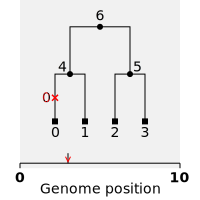

##fileformat=VCFv4.2
##source=tskit 0.5.3
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1	tsk_2	tsk_3
1	3	0	A	T	.	PASS	.	GT	1	0	0	0


In [5]:
import tskit
tables = tskit.Tree.generate_balanced(4, span=10).tree_sequence.dump_tables()
tables.sites.add_row(3, ancestral_state="A")
tables.mutations.add_row(site=0, node=0, derived_state="T")
ts = tables.tree_sequence()
display(ts.draw_svg())
display(ts)
ts.write_vcf(sys.stdout)

Here we define a tree sequence consisting of a single tree, which
has a variant site at position 3 and a mutation over node 0.
There is no information about individuals in this tree sequence,
and so we assume that each of the nodes corresponds to a single
haploid individual.

Users of msprime simulations would often be interested in producing
VCFs for diploid organisms. Because of the assumptions made
by these simulations, this means arbitrarily combining the sample
nodes into pairs. This is what the ``ploidy`` option does:

In [6]:
ts.write_vcf(sys.stdout, ploidy=2)

##fileformat=VCFv4.2
##source=tskit 0.5.3
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1
1	3	0	A	T	.	PASS	.	GT	1|0	0|0


Thus, the ``GT`` values for the (synthetic) diploid individual ``tsk_0``
are generated by combining nodes 0 and 1, and ``tsk_1``
by combining nodes 2 and 3.

:::{important}
Software packages modelling multiploid individuals are encouraged to
use the individual table to make their assumptions explicit. Recent
versions of simulators and inference methods should all do this,
and so the ``ploidy`` argument is really only intended to support
legacy code. It is therefore an error to supply a value for ``ploidy``
when individual information is present in a tree sequence.
:::

#### With individuals

Extending the example in the previous section, we add some individual data
defining a pair of diploid sibs and their parents.

:::{note}
We set the nodes for (e.g.) individual 2 to [1, 3] here to illustrate
that nodes for a given individual are not necessarily contiguous.
:::

In [7]:
tables.individuals.add_row(parents=[-1, -1])
tables.individuals.add_row(parents=[-1, -1])
tables.individuals.add_row(parents=[0, 1])
tables.individuals.add_row(parents=[0, 1])
node_individual = tables.nodes.individual
node_individual[[1, 3]] = 2
node_individual[[0, 2]] = 3
tables.nodes.individual = node_individual
display(tables.individuals)
display(tables.nodes)
ts = tables.tree_sequence()
ts.write_vcf(sys.stdout)

id,flags,location,parents,metadata
0,0,,"-1, -1",
1,0,,"-1, -1",
2,0,,"0, 1",
3,0,,"0, 1",


id,flags,population,individual,time,metadata
0,1,-1,3,0,
1,1,-1,2,0,
2,1,-1,3,0,
3,1,-1,2,0,
4,0,-1,-1,1,
5,0,-1,-1,1,
6,0,-1,-1,2,


##fileformat=VCFv4.2
##source=tskit 0.5.3
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1
1	3	0	A	T	.	PASS	.	GT	0|0	1|0


In this model we have four individuals defined, but only
individuals 2 and 3 are associated with nodes (more specifically,
**sample** nodes). Thus, we output **two** VCF sample individuals
composed of the linked nodes.

:::{note}
Note that the labels are ``tsk_0`` and ``tsk_1`` even though
the individual IDs are 2 and 3. See the
{ref}`sec_export_vcf_individual_names` section for how to change the
these default labels.
:::

(sec_export_vcf_individual_names)=

### Individual names

By default the VCF samples are given the labels ``tsk_0``, ``tsk_1``,
..., ``tsk_{N - 1}``, where ``N`` is the number of individuals to
be output (see the {ref}`sec_export_vcf_constructing_gt` section).

We can change this default labelling using the ``individual_names``
argument::

In [8]:
import sys
import msprime
ts = msprime.sim_ancestry(
    samples=3, ploidy=2, sequence_length=10, random_seed=2)
ts = msprime.sim_mutations(ts, rate=0.1, random_seed=2)
ts.write_vcf(sys.stdout, individual_names=["A", "B", "C"])

##fileformat=VCFv4.2
##source=tskit 0.5.3
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	A	B	C
1	2	0	A	T,G	.	PASS	.	GT	0|0	0|0	2|2
1	3	1	C	T	.	PASS	.	GT	0|0	0|1	0|0
1	4	2	G	C	.	PASS	.	GT	1|0	1|1	0|0
1	6	3	C	T	.	PASS	.	GT	1|0	1|1	0|0
1	9	4	A	C	.	PASS	.	GT	0|0	1|0	0|0


#### Exporting to plink

The default VCF sample IDs produced by ``tskit`` do not work well
with plink because it parses the individual
IDs based on a particular format, and does not allow ``0`` as a valid
identifier. We get an error like this:

```
Error: Sample ID ends with "_0", which induces an invalid IID of '0`.
```

This can be fixed by using the ``individual_names`` argument
to set the names to anything where the first name doesn't end with ``_0``.
An example implementation for diploid individuals is:

:::{code-block}
n_dip_indv = int(ts.num_samples / 2)
indv_names = [f"tsk_{i}indv" for i in range(n_dip_indv)]
with open("output.vcf", "w") as vcf_file:
    ts.write_vcf(vcf_file, individual_names=indv_names)
:::

Adding a second ``_`` (eg: ``tsk_0_indv``) is not recommended as
``plink`` uses ``_`` as the default separator for separating family
id and individual id, and two underscores will throw an error.

(sec_export_vcf_modifying_coordinates)=

### Modifying coordinates

Tskit supports continuous genome coordinates, but VCF only supports discrete
genome positions. Thus, when we convert a tree sequence that has sites
at continuous positions we must discretise the coordinates in some way.

The ``position_transform`` argument provides a way to flexibly translate
the genomic location of sites in tskit to the appropriate value in VCF.
There are two fundamental differences in the way that tskit and VCF define
genomic coordinates. The first is that tskit uses floating point values
to encode positions, whereas VCF uses integers. Thus, if the tree sequence
contains positions at non-integral locations there is an information loss
incurred by translating to VCF. By default, we round the site positions
to the nearest integer, such that there may be several sites with the
same integer position in the output. The second difference between VCF
and tskit is that VCF is defined to be a 1-based coordinate system, whereas
tskit uses 0-based. However, how coordinates are transformed depends
on the VCF parser, and so we do **not** account for this change in
coordinate system by default.

:::{note}
The msprime 0.x legacy API simulates using continuous coordinates. It may
be simpler to update your code to use the msprime 1.0 API (which uses
discrete coordinates by default) than to work out how to transform
coordinates in a way that is suitable for your application.
:::

:::{todo}
Provide some examples of using position transform.
:::